In [55]:
import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, TensorBoard
from keras import backend as keras
from tqdm import tqdm
import matplotlib.pyplot as plt
from glob import glob
import cv2

In [56]:
np.random.seed = 42

IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 1

TRAIN_RAW_PATH = 'Images/Head/head_training_set/hc_converted_raw/*.jpg'
#TRAIN_CONTRAST_PATH = "Images/Head/head_training_set/hc_contrast/*.png"
TRAIN_MASK_PATH = 'Images/Head/head_training_set/hc_mask/*.jpg'
TEST_PATH = 'Images/Head/head_test_set/*.jpg'

In [57]:
# train_raw_data = os.walk(TRAIN_RAW_PATH)[1]
# train_mask_data = os.walk(TRAIN_MASK_PATH)[1]
# test_data = os.walk(TEST_PATH)[1]

# X_train = np.zeros((len(train_raw_data), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
# Y_train = np.zeros((len(train_mask_data), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
# X_test = np.zeros((len(test_data), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)


In [58]:
X_train = np.zeros((59, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((59, IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)
X_test = np.zeros((40, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)

print("Resizing training, test images and masks")

Resizing training, test images and masks


In [59]:
# alpha = 1.5
# beta = 0
# contrast_counter = 0
# for img in glob(TRAIN_RAW_PATH):
#     image = io.imread(img)
#     adjusted_image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
#     io.imsave(os.path.join("Images/Head/head_training_set/hc_contrast", "%d_HC_contrast.png"%contrast_counter),adjusted_image)
#     contrast_counter+=1

In [60]:
index_counter = 0
for rawImage in glob(TRAIN_RAW_PATH):
    image = io.imread(rawImage)
    image = trans.resize(image, (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), mode='constant', preserve_range=True)
    X_train[index_counter]=image
    index_counter+=1

index_counter = 0

# for maskImage in os.listdir(TRAIN_MASK_PATH):
#     image = io.imread(os.path.join(TRAIN_MASK_PATH, maskImage), pilmode="RGB")
#     image = trans.resize(image, (IMG_HEIGHT, IMG_WIDTH,1), mode='constant', preserve_range=True)
#     Y_train[index_counter]=image
#     index_counter+=1
    
for maskImage in glob(TRAIN_MASK_PATH):
    image = io.imread(maskImage)
    image = trans.resize(image, (IMG_HEIGHT, IMG_WIDTH, 1), mode='constant', preserve_range=True)
    Y_train[index_counter]=image
    index_counter+=1
    
index_counter = 0

for img in glob(TEST_PATH):
    image = io.imread(img)
    image = trans.resize(image, (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), mode='constant', preserve_range=True)
    X_test[index_counter]=image
    index_counter+=1
    
    
print("Done with test and train image resizing")

Done with test and train image resizing


X_test


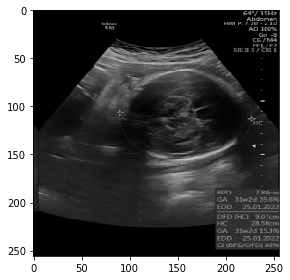

X_train


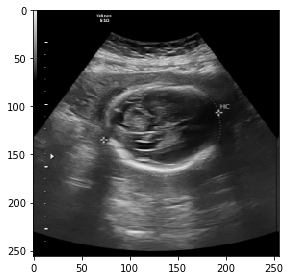

Y_train


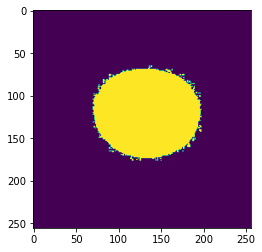

In [61]:
index = np.random.randint(0, 40)
print('X_test')
io.imshow(X_test[index])
plt.show()
print('X_train')
io.imshow(X_train[index])
plt.show()
print('Y_train')
plt.imshow(np.squeeze(Y_train[index]))

In [62]:
input_size = (IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS)
inputs = Input(input_size)
float_inputs = Lambda(lambda x:x / 512)(inputs)

conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(float_inputs)
conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
drop4 = Dropout(0.5)(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
drop5 = Dropout(0.5)(conv5)

up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
merge6 = concatenate([drop4,up6], axis = 3)
conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
merge7 = concatenate([conv3,up7], axis = 3)
conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
merge8 = concatenate([conv2,up8], axis = 3)
conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
merge9 = concatenate([conv1,up9], axis = 3)
conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)
    
model = Model(inputs = inputs, outputs = conv10)

def dice_coefficient(y_true, y_pred, smooth = 1 ):
    y_true_f = keras.flatten(y_true)
    y_pred_f = keras.flatten(y_pred)
    intersection = keras.sum(y_true_f * y_pred_f)
    return (2 * intersection + smooth) / (keras.sum(y_true_f) + keras.sum(y_pred_f) + smooth)
    
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy' , dice_coefficient] )

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 lambda_2 (Lambda)              (None, 256, 256, 1)  0           ['input_3[0][0]']                
                                                                                                  
 conv2d_48 (Conv2D)             (None, 256, 256, 64  640         ['lambda_2[0][0]']               
                                )                                                                 
                                                                                            

In [64]:
checkpoint = ModelCheckpoint('model_for_hc.h5', verbose=1, save_best_only=True)
callbacks = [EarlyStopping(patience=2, monitor="val_loss"), TensorBoard(log_dir="logs")]

results = model.fit(X_train, Y_train, batch_size=16, steps_per_epoch=1, epochs=2, callbacks=callbacks)

Epoch 1/2
1/1 [==============================] - 34s 34s/step - loss: 0.6911 - accuracy: 0.8140 - dice_coefficient: 0.2715
Epoch 2/2
1/1 [==============================] - 30s 30s/step - loss: 0.6783 - accuracy: 0.8510 - dice_coefficient: 0.2332


In [65]:
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

2/2 [==============================] - 14s 3s/step


In [66]:
for i,item in enumerate(preds_test):
    io.imsave(os.path.join("Images/Head/result","%d_HC_predict.png"%i),item)

C:\Users\User\AppData\Local\Temp/ipykernel_13180/1343858603.py:2: UserWarning: Images/Head/result\0_HC_predict.png is a low contrast image
  io.imsave(os.path.join("Images/Head/result","%d_HC_predict.png"%i),item)
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
C:\Users\User\AppData\Local\Temp/ipykernel_13180/1343858603.py:2: UserWarning: Images/Head/result\1_HC_predict.png is a low contrast image
  io.imsave(os.path.join("Images/Head/result","%d_HC_predict.png"%i),item)
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
C:\Users\User\AppData\Local\Temp/ipykernel_13180/1343858603.py:2: UserWarning: Images/Head/result\2_HC_predict.png is a low contrast image
  io.imsave(os.path.join("Images/Head/result","%d_HC_predict.png"%i),item)
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
C

C:\Users\User\AppData\Local\Temp/ipykernel_13180/1343858603.py:2: UserWarning: Images/Head/result\25_HC_predict.png is a low contrast image
  io.imsave(os.path.join("Images/Head/result","%d_HC_predict.png"%i),item)
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
C:\Users\User\AppData\Local\Temp/ipykernel_13180/1343858603.py:2: UserWarning: Images/Head/result\26_HC_predict.png is a low contrast image
  io.imsave(os.path.join("Images/Head/result","%d_HC_predict.png"%i),item)
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
C:\Users\User\AppData\Local\Temp/ipykernel_13180/1343858603.py:2: UserWarning: Images/Head/result\27_HC_predict.png is a low contrast image
  io.imsave(os.path.join("Images/Head/result","%d_HC_predict.png"%i),item)
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning

Showing X_train


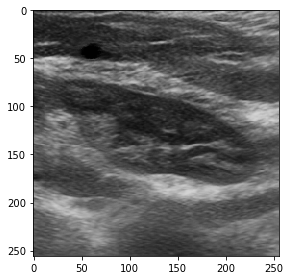

Showing Y_train
Showing preds_train_t


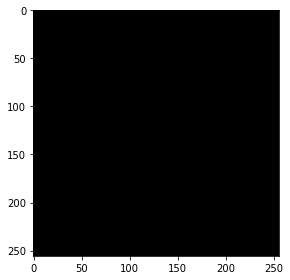

Showing X_train after shaping


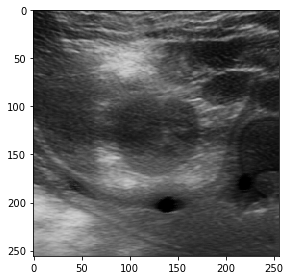

Showing Y_train after shaping
Showing preds_val_t


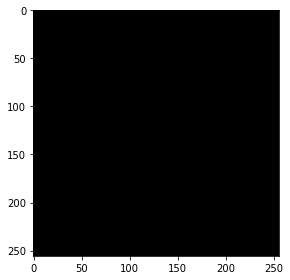

In [15]:
ix = np.random.randint(0, len(preds_train_t))
print("Showing X_train")
io.imshow(X_train[ix])
plt.show()
print("Showing Y_train")
plt.imshow(np.squeeze(Y_train[ix]))

print("Showing preds_train_t")
io.imshow(np.squeeze(preds_train_t[ix]))
plt.show()

ix = np.random.randint(0, len(preds_val_t))
print("Showing X_train after shaping")
io.imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()

print("Showing Y_train after shaping")
plt.imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))

print("Showing preds_val_t")
io.imshow(np.squeeze(preds_val_t[ix]))
plt.show()

#     if(pretrained_weights):
#     	model.load_weights(pretrained_weights)

#     return model